In [1]:
import shutup
shutup.please()

In [2]:
import numpy as np

from src.agents.agent import Agent
from src.utils.buffer import Buffer

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp
from tensorflow.keras.layers import Input, Dense, Concatenate



In [5]:
class ActorCriticAgent(Agent):
    def __init__(self, 
                environment, 
                alpha = 0.01,
                gamma = 0.99,
                eps = np.finfo(np.float32).eps.item(),
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
                critic_loss= tf.keras.losses.Huber()):
        
        super(ActorCriticAgent, self).__init__(environment)
        
        # Args
        self.alpha = alpha
        self.gamma = gamma 
        self.eps = eps 
        self.optimizer=optimizer
        self.critic_loss = critic_loss
        #type(tf.keras.optimizers.Adam(learning_rate=0.01)).__name__

        self.__init_networks()
        self.__init_buffers()
        
    def __init_buffers(self):
        self.buffer = Buffer(['action_log_probs','critic_values','rewards'])
            
    def __init_networks(self):
        num_inputs = self.observation_shape[0]
        num_hidden = 128

        inputs = Input(shape=(num_inputs,),name="actor_critic_inputs")
        common_layer = Dense(num_hidden, activation="relu", name="actor_critic_common_layer")(inputs)
        
        if self.action_space_mode == "discrete":
            action = Dense(self.n_actions, activation="softmax")(common_layer)
        elif self.action_space_mode == "continuous":
            mu_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
            mu = Dense(self.n_actions, activation="tanh" , name='mu',kernel_initializer=mu_init)(common_layer)
            
            sigma_init = tf.random_uniform_initializer(minval=self.eps, maxval=0.2)
            sigma = Dense(self.n_actions, activation="softplus", name="sigma", kernel_initializer=sigma_init)(common_layer)
            
            action = Concatenate(axis=-1, name="actor_output")([mu,sigma]) * self.action_upper_bounds

        critic = Dense(1)(common_layer)

        self.model = keras.Model(inputs=inputs, outputs=[action, critic])

    def choose_action(self, state, deterministic=True):
        action_probs, critic_value = self.model(state)
        
        if self.action_space_mode == "discrete":
            # DISCRETE SAMPLING
            if deterministic:
                action = np.argmax(np.squeeze(action_probs))
                action_log_prob = action
            else:
                # Sample action from action probability distribution
                action = np.random.choice(self.n_actions, p=np.squeeze(action_probs))
                action_log_prob = tf.math.log(action_probs[0, action])


        elif self.action_space_mode == "continuous":
            # CONTINUOUS SAMPLING
            mu = action_probs[:,0:self.n_actions]
            sigma = action_probs[:,self.n_actions:]
            
            if deterministic:
                action = mu
                action_log_prob = action
            else:
                norm_dist = tfp.distributions.Normal(mu, sigma)
                action = tf.squeeze(norm_dist.sample(self.n_actions), axis=0)
                action_log_prob = -(norm_dist.log_prob(action)+self.eps)
                action = tf.clip_by_value(
                    action, self.env.action_space.low[0], 
                    self.env.action_space.high[0])

                action = np.array(action[0],dtype=np.float32)
        
        return action, action_log_prob , critic_value
    
    def test(self, episodes=10, render=True):

        for episode in range(episodes):
            try:
                state = self.env.reset()
            except:
                self._Agent__init_environment()
                state = self.env.reset()
                
            done = False
            score = 0
            while not done:
                if render:
                    self.env.render()
                
                state = tf.convert_to_tensor(state)
                state = tf.expand_dims(state, 0)
                
                # Sample action, probs and critic
                action, action_log_prob, critic_value = self.choose_action(state)

                # Step
                state,reward,done, info = self.env.step(action)

                # Get next state
                score += reward
            
            if render:
                self.env.close()

            self.learning_log.episode_test_log(score,episode)
    
    def learn(self, timesteps=-1, plot_results=True, reset=False, log_each_n_episodes=100, success_threshold=False,log_level=1):
        
        self.validate_learn(timesteps,success_threshold,reset)
        success_threshold = success_threshold if success_threshold else self.env.success_threshold
 
        self.buffer.reset()
        score = 0
        timestep = 0
        episode = 0
        
        while self.learning_condition(timesteps,timestep):  # Run until solved
            state = self.env.reset()
            score = 0
            done = False
            with tf.GradientTape() as tape:
                while not done:

                    state = tf.convert_to_tensor(state)
                    state = tf.expand_dims(state, 0)

                    # Predict action probabilities and estimated future rewards
                    # from environment state
                    action, action_log_prob, critic_value = self.choose_action(state, deterministic=False)

                    self.buffer.store('critic_values',critic_value[0, 0])

                    # Sample action from action probability distribution
                    self.buffer.store('action_log_probs',action_log_prob)

                    # Apply the sampled action in our environment
                    state, reward, done, _ = self.env.step(action)
                    self.buffer.store('rewards',reward)

                    score += reward
                    timestep+=1
                # Update running reward to check condition for solving
                self.running_reward.step(score)

                # Time discounted rewards
                returns = []
                discounted_sum = 0
                
                for r in self.buffer.get('rewards')[::-1]:
                    discounted_sum = r + self.gamma * discounted_sum
                    returns.insert(0, discounted_sum)

                # Normalize
                returns = np.array(returns)
                returns = (returns - np.mean(returns)) / (np.std(returns) + self.eps)
                returns = returns.tolist()

                # Calculating loss values to update our network
                history = zip(self.buffer.get('action_log_probs'), self.buffer.get('critic_values'), returns)
                actor_losses = []
                critic_losses = []
                for log_prob, value, ret in history:
                    # At this point in history, the critic estimated that we would get a
                    # total reward = `value` in the future. We took an action with log probability
                    # of `log_prob` and ended up recieving a total reward = `ret`.
                    # The actor must be updated so that it predicts an action that leads to
                    # high rewards (compared to critic's estimate) with high probability.
                    diff = ret - value
                    actor_losses.append(-log_prob * diff)  # actor loss

                    # The critic must be updated so that it predicts a better estimate of
                    # the future rewards.
                    critic_losses.append(
                        self.critic_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
                    )

                # Backpropagation
                loss_value = sum(actor_losses) + sum(critic_losses)
                #print(loss_value)
                grads = tape.gradient(loss_value, self.model.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

                # Clear the loss and reward history
                self.buffer.reset()

            # Log details
            episode += 1
            self.learning_log.episode(
                log_each_n_episodes,
                score,
                self.running_reward.reward, 
                log_level=log_level
            )

            if self.did_finnish_learning(success_threshold,episode):
                break

        if plot_results:
            self.plot_learning_results()






| ---------------------------------
| CartPole-v1
| Action space: Discrete with high state-space
| Environment beated threshold: 200
| Dev notes:
|   * Agents that track State/Action combinations like 
|     Q learning will fail due to high state space
| ----------------------------------------------------------   


Episode * 10 * Moving Avg Reward is ==> 24.600 * Last Reward was ==> 9.000
Episode * 20 * Moving Avg Reward is ==> 17.900 * Last Reward was ==> 10.000
Episode * 30 * Moving Avg Reward is ==> 15.967 * Last Reward was ==> 23.000
Episode * 40 * Moving Avg Reward is ==> 18.250 * Last Reward was ==> 30.000
Episode * 50 * Moving Avg Reward is ==> 22.380 * Last Reward was ==> 15.000
Episode * 60 * Moving Avg Reward is ==> 38.680 * Last Reward was ==> 355.000
Episode * 70 * Moving Avg Reward is ==> 73.400 * Last Reward was ==> 22.000
Episode * 80 * Moving Avg Reward is ==> 74.540 * Last Reward was ==> 18.000
Episode * 90 * Moving Avg Reward is ==> 72.920 * Last Reward was ==> 19.

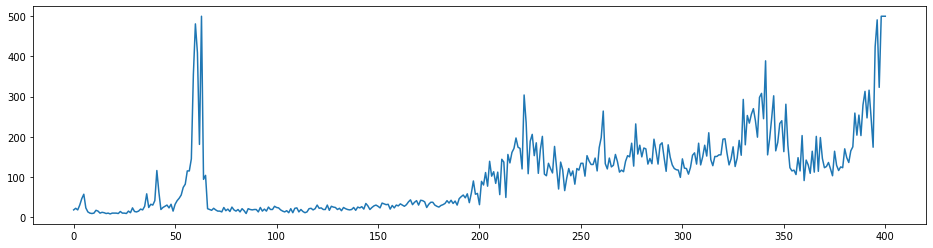

In [7]:
from src.environments.discrete.cartpole import environment
agent_discrete = ActorCriticAgent(environment)
agent_discrete.learn(log_each_n_episodes=10)

#{'action': 0, 'action_log_prob': <tf.Tensor: shape=(), dtype=float32, numpy=-0.6900733>}

In [8]:
agent_discrete.test(render=False)

Episode done * Score ==> 260.000
Episode * 1 * Score ==> 500.000
Episode * 2 * Score ==> 257.000
Episode * 3 * Score ==> 500.000
Episode * 4 * Score ==> 500.000
Episode * 5 * Score ==> 500.000
Episode * 6 * Score ==> 269.000
Episode * 7 * Score ==> 500.000
Episode * 8 * Score ==> 500.000
Episode * 9 * Score ==> 500.000


In [ ]:
from src.environments.continuous.inverted_pendulum import environment

agent_continuous = ActorCriticAgent(environment,optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001))
agent_continuous.learn(log_each_n_episodes=100)

#{'action': array([0.6679693], dtype=float32), 'action_log_prob': array([1.0068668], dtype=float32)}

Episode * 100 * Moving Avg Reward is ==> 25.640 * Last Reward was ==> 23.000
Episode * 200 * Moving Avg Reward is ==> 21.440 * Last Reward was ==> 23.000
Episode * 300 * Moving Avg Reward is ==> 22.220 * Last Reward was ==> 27.000


In [ ]:
agent_continuous.test()